In [19]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
from scipy.optimize import minimize
from typing import List, Dict, Tuple, Optional, Union
import argparse
from collections import defaultdict
import time
from tqdm import tqdm

# 1.Load data

In [7]:
sigmoid = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv", sep="\t", index_col=[0,1,2,3])
piecewise_noFix = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/Piecewise_Linear_Function_curve_fitting/Gene_level_LFC_fitted.tsv", sep="\t", index_col=[0,1,2,3])
piecewise_fixA = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/Piecewise_Linear_Function_curve_fitting/Gene_level_LFC_fitted_fixA.tsv", sep="\t", index_col=[0,1,2,3])

In [42]:
piecewise_noFix["Status"].value_counts()

Status
Success                4495
Optimization failed      24
Name: count, dtype: int64

In [43]:
piecewise_fixA["Status"].value_counts()

Status
Success    4519
Name: count, dtype: int64

In [8]:
merged_data1 = pd.merge(sigmoid, piecewise_noFix, left_index=True, right_index=True, how="inner", suffixes=("_sigmoid", "_piecewise"))
merged_data2 = pd.merge(sigmoid, piecewise_fixA, left_index=True, right_index=True, how="inner", suffixes=("_sigmoid", "_piecewise"))
merged_data3 = pd.merge(piecewise_noFix, piecewise_fixA, left_index=True, right_index=True, how="inner", suffixes=("_noFix", "_fixA"))

# 2.Statistic analysis

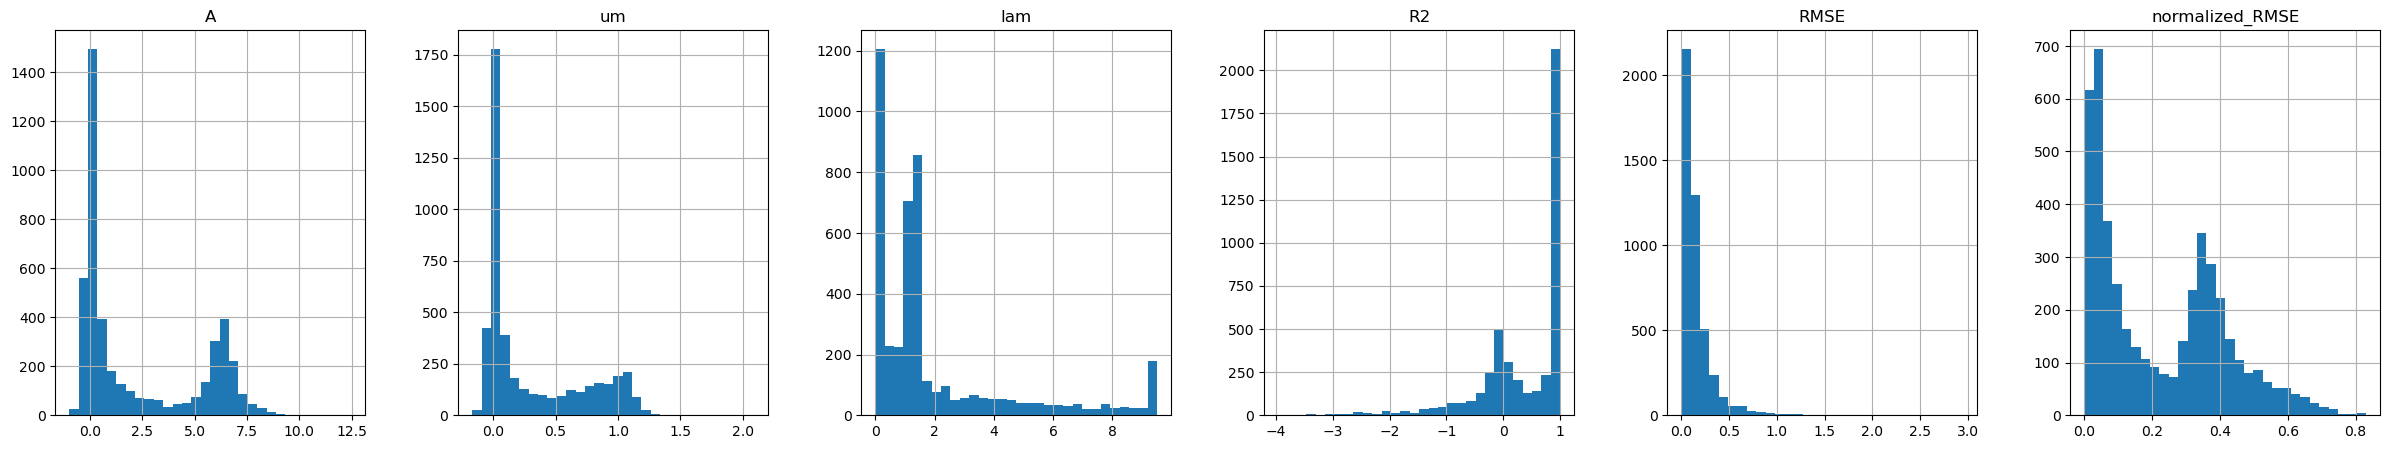

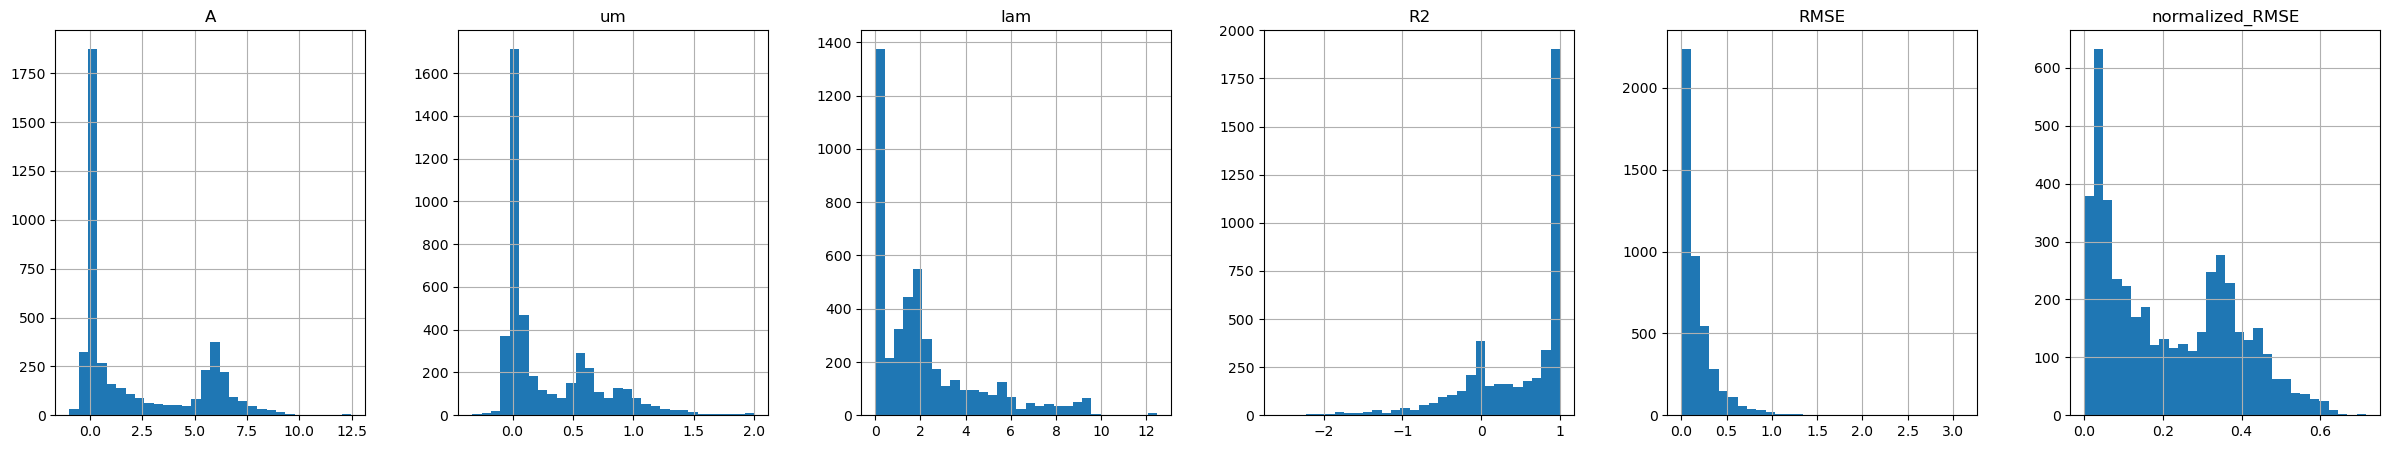

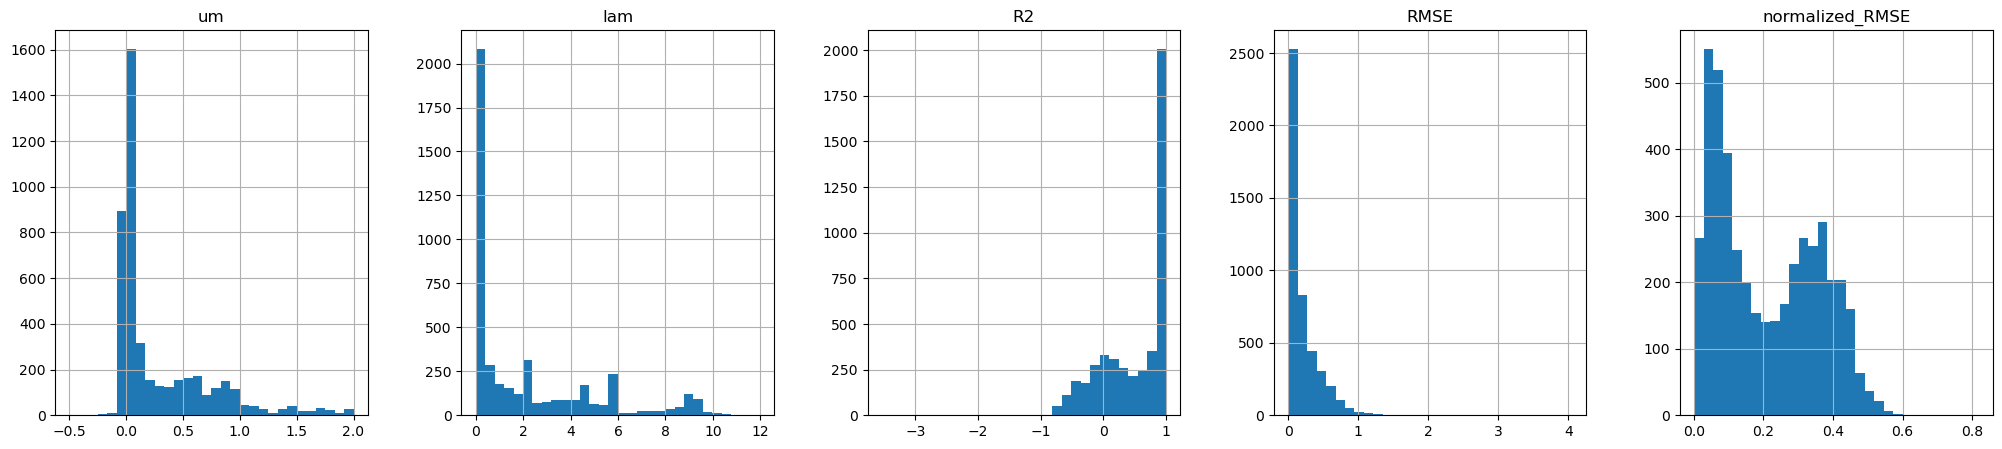

In [9]:
for data in [sigmoid, piecewise_noFix, piecewise_fixA]:
    metrics_columns = ["um", "lam", "R2", "RMSE", "normalized_RMSE"]
    if "A" in data.columns:
        metrics_columns = ["A"] + metrics_columns
    data[metrics_columns].hist(bins=30, figsize=(5*len(metrics_columns), 5), layout=(1, len(metrics_columns)))
    plt.show()
    plt.close()

# 3.Comparision

In [10]:
def fitting_value_comparison(merged_data, params, suffixes):

    suffixe1, suffixe2 = suffixes

    n_cols = len(params)
    # Create scatter plots for comparison
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
    axes = axes.flatten()

    for col, param in enumerate(params):
        # Get data for both methods
        vals1 = merged_data[f'{param}_{suffixe1}']
        vals2 = merged_data[f'{param}_{suffixe2}']

        vals1, vals2 = vals1[vals1.notna() & vals2.notna()], vals2[vals1.notna() & vals2.notna()]
        
        xy = np.vstack([vals1, vals2])
        z = gaussian_kde(xy)(xy)
        
        # Create scatter plot
        axes[col].scatter(vals1, vals2, alpha=0.6, s=20, c=z, cmap='viridis', edgecolors='none')
        
        # Add diagonal line for perfect correlation
        min_val = min(vals1.min(), vals2.min())
        max_val = max(vals1.max(), vals2.max())
        axes[col].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        # Set labels and title
        axes[col].set_xlabel(f'{param} ({suffixe1})')
        axes[col].set_ylabel(f'{param} ({suffixe2})')
        axes[col].set_title(f'{param} Comparison')
        axes[col].grid(True, alpha=0.3)
        
        # Calculate and display correlation
        correlation = np.corrcoef(vals1, vals2)[0, 1]
        axes[col].text(0.05, 0.95, f'r = {correlation:.3f}', 
                        transform=axes[col].transAxes, 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()
    plt.close()


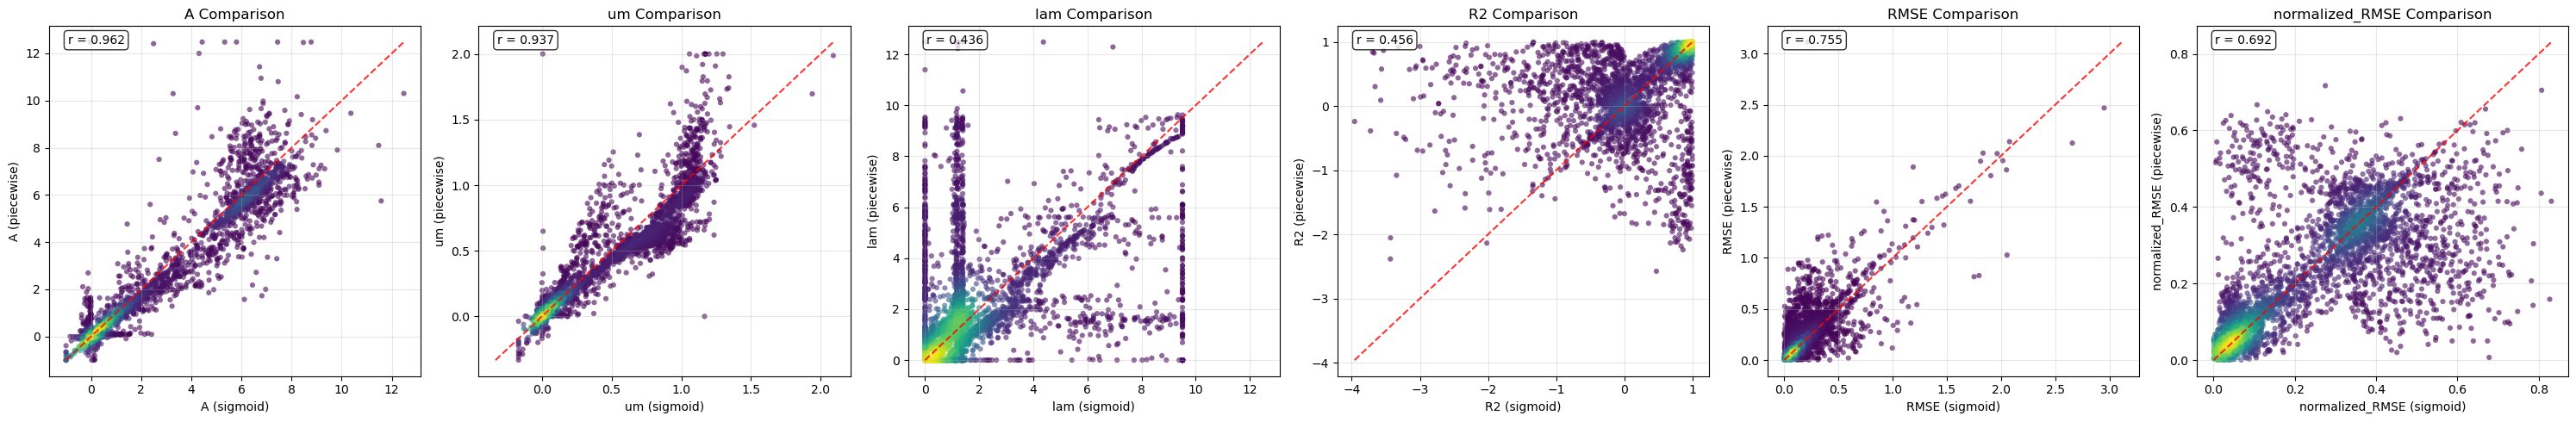

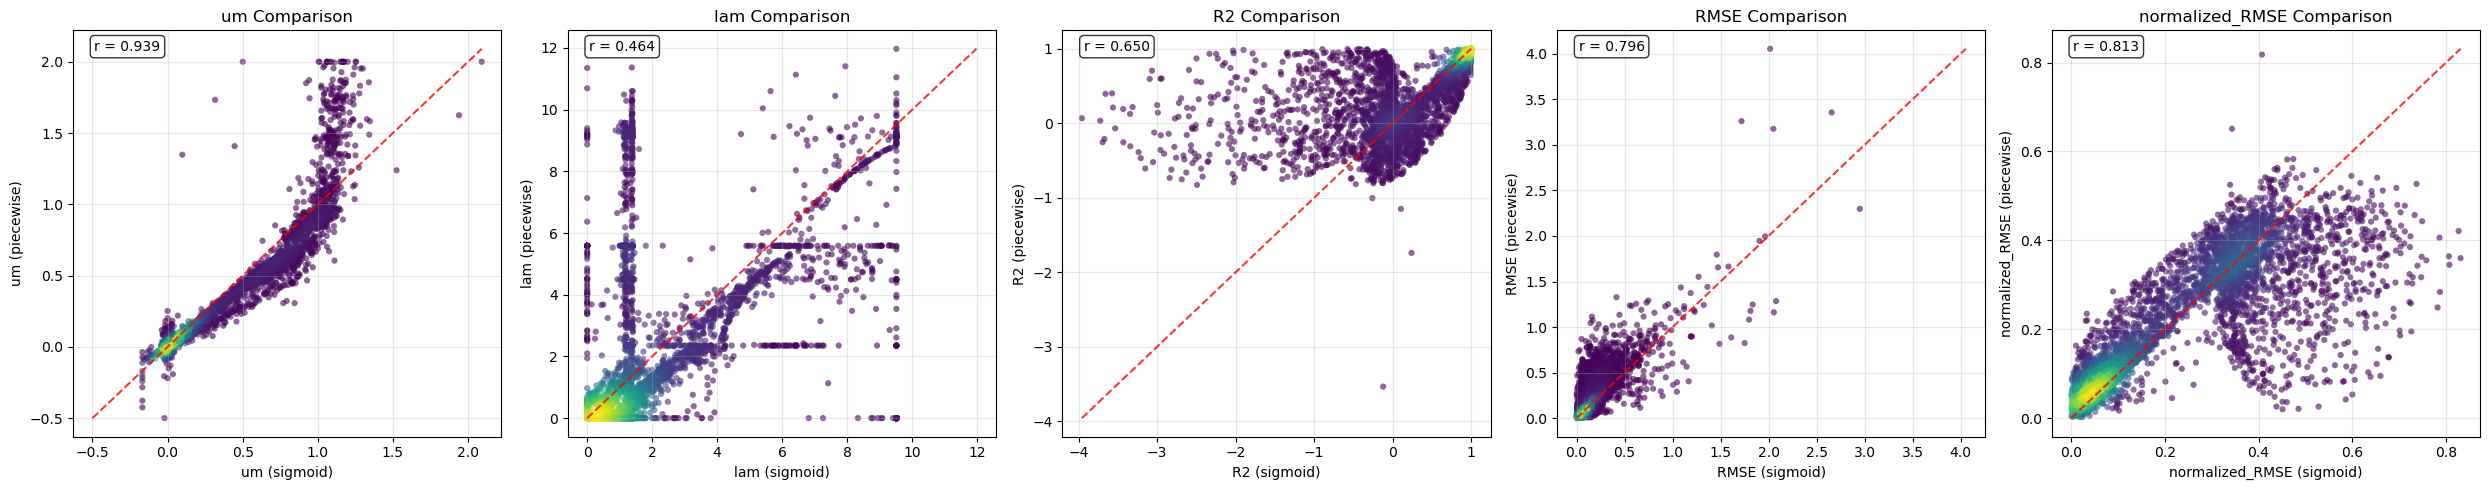

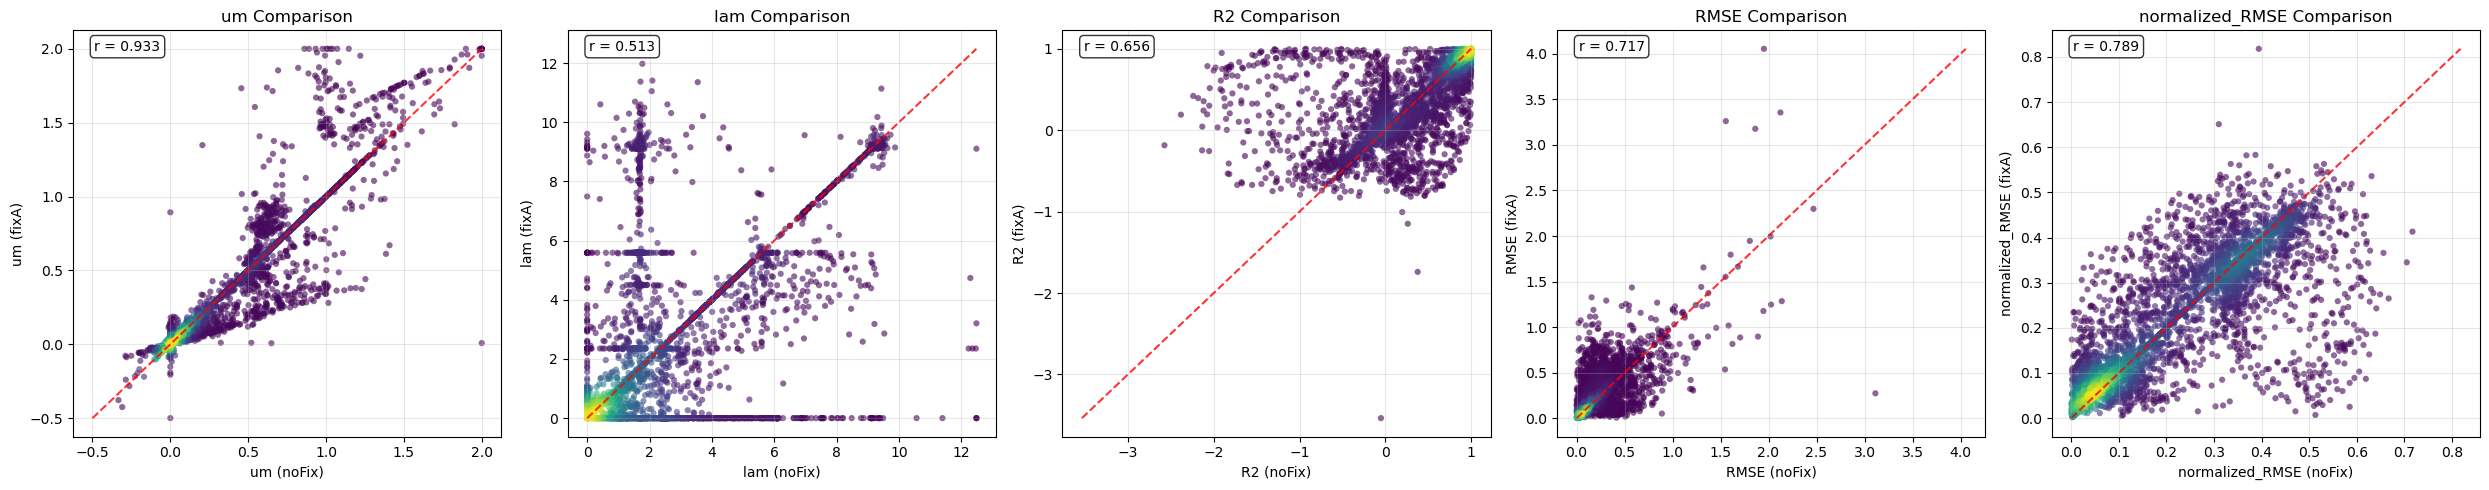

In [11]:
for merged_data in [merged_data1, merged_data2, merged_data3]:
    metrics_columns = ["um", "lam", "R2", "RMSE", "normalized_RMSE"]
    um_columns = merged_data.filter(like='um').columns.tolist()
    suffixes = tuple("_".join(col.split('_')[1:]) for col in um_columns)
    if "A_" + suffixes[0] in merged_data.columns:
        metrics_columns.insert(0, "A")
        fitting_value_comparison(merged_data, metrics_columns, suffixes)
    else:
        fitting_value_comparison(merged_data, metrics_columns, suffixes)

In [38]:
plt.rcParams.update({
    'figure.max_open_warning': 0,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8
})

# Color palette following cursor rules
COLOR_PALETTE = {
    'primary_purple': '#962955',
    'primary_green': '#7fb775', 
    'primary_blue': '#6479cc',
    'primary_gold': '#ad933c',
    'fit_line': '#962955',
    'data_points': '#6479cc',
    'constraint_lines': '#333333'
}

def piecewise_linear_function(x: np.ndarray, A: float, um: float, lam: float) -> np.ndarray:
    """
    Piecewise Linear Function
    """
    # Avoid division by zero when um is zero or very close to zero
    y = np.piecewise(x, 
                        [
                            x < lam, 
                            (x >= lam) & (x <= lam + abs(A)/(abs(um)+1e-10)),
                            x > lam + abs(A)/(abs(um)+1e-10)
                        ], 
                        [
                            0, 
                            lambda x: um * (x - lam),
                            A
                        ]
                    )
    return y

def piecewise_linear_fixA_function(x: np.ndarray, um: float, lam: float) -> np.ndarray:
    """
    Piecewise Linear Function
    """
    A = 6.5
    # Avoid division by zero when um is zero or very close to zero
    y = np.piecewise(x, 
                        [
                            x < lam, 
                            (x >= lam) & (x <= lam + abs(A)/(abs(um)+1e-10)),
                            x > lam + abs(A)/(abs(um)+1e-10)
                        ], 
                        [
                            0, 
                            lambda x: um * (x - lam),
                            A
                        ]
                    )
    return y

def gompertz_function(x: np.ndarray, A: float, um: float, lam: float) -> np.ndarray:
    """
    Calculate Gompertz function values with numerical stability.
    
    Args:
        x: Input time points
        A: Maximum depletion level (asymptote)
        um: Maximum depletion rate
        lam: Lag time parameter
        
    Returns:
        Gompertz function values at input points
    """
    # Check for division by zero
    if A == 0:
        return np.zeros_like(x)
    
    exponent = np.clip((um * np.e / A) * (lam - x) + 1, -700, 700)
    return A * np.exp(-np.exp(exponent))

def create_fitted_plot(ax: plt.Axes, x_values: np.ndarray, y_values: np.ndarray, 
                      params: Dict[str, Union[str, float]], ID: str) -> None:
    """
    Create a publication-quality plot for fitted curve.
    
    Args:
        ax: Matplotlib axes object
        x_values: Time points
        y_values: Depletion measurements
        params: Fitted parameters
        ID: Gene/insertion identifier
    """
    ax.grid(True, alpha=0.3)

    # Plot data points
    ax.scatter(x_values, y_values, 
                color=COLOR_PALETTE['data_points'], 
                s=50, alpha=0.8, 
                edgecolors='white', linewidth=0.5,
                label='Data')
    
    x_smooth = np.linspace(min(x_values), max(x_values), 100)

    ums = [ x for x in params.keys() if "um" in x]
    suffixes = [x.split("_")[1] for x in ums]
    for idx, suffix in enumerate(suffixes):
        if ('Status_'+suffix in params) and (params['Status_'+suffix] == 'Success'): 
            um, lam = params[f'um_{suffix}'], params[f'lam_{suffix}']
            
            if ("A" in params) and ("sigmoid" in suffixes):
                if suffix == "sigmoid":
                    A = params["A"]
                    y_fit = gompertz_function(x_smooth, A, um, lam)
                else:
                    A = 6.5
                    y_fit = piecewise_linear_fixA_function(x_smooth, um, lam)
            elif "sigmoid" in suffixes:
                A = params[f"A_{suffix}"]
                if suffix == "sigmoid":
                    y_fit = gompertz_function(x_smooth, A, um, lam)
                else:
                    y_fit = piecewise_linear_function(x_smooth, A, um, lam)
            else:
                if suffix == "noFix":
                    A = params[f"A_{suffix}"]
                    y_fit = gompertz_function(x_smooth, A, um, lam)
                elif suffix == "fixA":
                    A = 6.5
                    y_fit = piecewise_linear_fixA_function(x_smooth, um, lam)
            
            ax.plot(x_smooth, y_fit, linewidth=2.0, label=suffix)
            
            # Add constraint lines with subtle styling
            ax.axhline(y=A, linestyle='--', alpha=0.3, linewidth=1.0)
            ax.axvline(x=lam, linestyle='--', alpha=0.3, linewidth=1.0)
            # add the straight line that crosses with the x axis at x=lam, and with the slope of um
            x_line = np.linspace(lam-1, 14, 100)
            y_line = um * (x_line - lam)
            ax.plot(x_line, y_line, linestyle='--', alpha=0.3, linewidth=1.0)
            
            # Add parameter text
            param_text = f'{suffix}:\nA={A:.2f}\num={um:.2f}\nlam={lam:.2f}'
            ax.text(0.05+0.5*(idx+1), 0.75, param_text, 
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top')
    
    ax.set_ylim(-1.5, 8.5)
    ax.set_title(ID, fontsize=9, pad=5)
    ax.tick_params(labelsize=8)


def generate_fitting_plots(results_df: pd.DataFrame, output_plot: Path) -> None:
    """
    Generate multi-page PDF with fitting plots.
    
    Args:
        results_df: DataFrame with fitting results
        x_values: Time points
        y_values: Depletion data matrix
        output_plot: Output PDF path
    """
    x_values = [0.0, 2.352, 5.588, 9.104, 12.48]
    if "t0_sigmoid" in results_df.columns:
        y_values = results_df[["t0_sigmoid", "t1_sigmoid", "t2_sigmoid", "t3_sigmoid", "t4_sigmoid"]].values
    elif "t0_piecewise" in results_df.columns:
        y_values = results_df[["t0_piecewise", "t1_piecewise", "t2_piecewise", "t3_piecewise", "t4_piecewise"]].values
    elif "t0_piecewise_noFix" in results_df.columns:
        y_values = results_df[["t0_piecewise_noFix", "t1_piecewise_noFix", "t2_piecewise_noFix", "t3_piecewise_noFix", "t4_piecewise_noFix"]].values

    plots_per_page = 32
    num_pages = int(np.ceil(len(results_df) / plots_per_page))
    
    logging.info(f"Generating {num_pages} pages of plots...")
    
    with PdfPages(output_plot) as pdf:
        for page in range(num_pages):
            fig, axes = plt.subplots(8, 4, figsize=(8.27, 11.69))  # A4 landscape
            axes = axes.flatten()

            # progress bar
            if page % 10 == 0:
                logging.info(f"Generating page {page+1} of {num_pages}...")
            
            start_idx = page * plots_per_page
            end_idx = min((page + 1) * plots_per_page, len(results_df))
            
            for idx in range(start_idx, end_idx):
                ax_idx = idx % plots_per_page
                row = results_df.iloc[idx]
                ID = " ".join(map(str, row.name))
                
                create_fitted_plot(
                    axes[ax_idx], 
                    x_values, 
                    y_values[idx], 
                    row.to_dict(),
                    ID
                )
            
            # Hide unused subplots
            for ax_idx in range(end_idx - start_idx, plots_per_page):
                axes[ax_idx].set_visible(False)
            
            plt.tight_layout(pad=1.0)
            pdf.savefig(fig, bbox_inches='tight', dpi=300)
            plt.close(fig)

In [39]:
generate_fitting_plots(merged_data2[(merged_data2["um_sigmoid"] - merged_data2["um_piecewise"] <  -0.2)], output_plot=Path("../tmp/Sigmoid_vs_fixA_comparison_plot.pdf"))

In [40]:
generate_fitting_plots(merged_data1[(merged_data1["um_sigmoid"] - merged_data1["um_piecewise"] <  -0.2) & (merged_data1["um_sigmoid"] < 0.75)], output_plot=Path("../tmp/Sigmoid_vs_noFix_comparison_plot.pdf"))

In [41]:
merged_data1[(merged_data1["um_sigmoid"] - merged_data1["um_piecewise"] <  -0.2) & (merged_data1["um_sigmoid"] < 0.75)]

,,,,time_points_sigmoid,Status_sigmoid,A_sigmoid,um_sigmoid,lam_sigmoid,R2_sigmoid,RMSE_sigmoid,normalized_RMSE_sigmoid,t0_sigmoid,t1_sigmoid,...,t0_fitted_piecewise,t1_fitted_piecewise,t2_fitted_piecewise,t3_fitted_piecewise,t4_fitted_piecewise,t0_residual_piecewise,t1_residual_piecewise,t2_residual_piecewise,t3_residual_piecewise,t4_residual_piecewise
Systematic ID,Name,FYPOviability,DeletionLibrary_essentiality,,,,,,,,,,,,,,,,,,,,,
SPAC1071.02,mms19,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,3.325,0.388,0.963,0.998,0.046,0.015,0.0,0.608,...,0.0,0.608,2.527,2.527,2.527,0.0,0.000,-0.737,0.137,0.601
SPAC10F6.01c,sir1,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,2.063,0.139,0.630,0.696,0.341,0.180,0.0,0.636,...,0.0,0.636,1.049,1.049,1.049,0.0,0.000,-0.408,-0.437,0.845
SPAC1142.07c,vps32,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.069,0.372,0.502,0.887,0.513,0.120,0.0,0.584,...,0.0,0.584,2.605,3.305,3.305,0.0,0.000,0.000,-0.971,0.971
SPAC1142.08,fhl1,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,2.216,0.311,0.841,0.960,0.169,0.075,0.0,0.567,...,0.0,0.567,1.830,1.830,1.830,0.0,0.000,-0.575,0.422,0.153
SPAC11E3.07,vma4,inviable,E,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.107,0.363,1.426,0.974,0.219,0.056,0.0,0.805,...,0.0,0.806,2.465,2.465,2.465,0.0,-0.001,-0.986,-0.015,1.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPCC965.03,vma8,inviable,E,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.421,0.412,2.319,0.977,0.222,0.054,0.0,0.360,...,0.0,0.000,1.584,3.236,3.236,0.0,0.360,0.000,-0.849,0.849
SPCC970.10c,brl2,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,3.607,0.260,0.702,0.982,0.132,0.048,0.0,0.699,...,0.0,0.698,2.028,2.028,2.028,0.0,0.001,-0.890,0.183,0.708
SPCP1E11.09c,rpp103,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,2.790,0.239,-0.000,0.895,0.271,0.113,0.0,1.116,...,0.0,1.116,1.848,1.848,1.848,0.0,0.000,-0.730,0.175,0.556
